In [3]:
import os
import cooler
import cooltools.snipping
import bioframe
import pandas as pd
from NGS import HiCTools as HT
from collections import defaultdict
import re
import numpy as np
from typing import Callable
import matplotlib.pyplot as plt
import seaborn as sbn
from scipy.stats import ttest_ind, mannwhitneyu
import matplotlib.colors as cl
import matplotlib
import warnings
from typing import Tuple

In [4]:
# ignore warnings (log10(0))
warnings.simplefilter("ignore", RuntimeWarning)

# Define plotting parameters

In [5]:
matplotlib.rcParams.update({"font.size": 12})
matplotlib.rcParams.update({"pdf.fonttype": 42})

# Define functions

In [6]:
def recDict():
    return defaultdict(recDict)

def getPairingScoreObsExp(clr: cooler.Cooler, expected: pd.DataFrame ,windowsize: int = 4 * 10**4,
                    func: Callable = np.mean, regions: pd.DataFrame = pd.DataFrame(),
                    norm: bool = True) -> pd.DataFrame:
    """Takes a cooler file (clr),
    a windowsize (windowsize), a summary
    function (func) and a set of genomic
    regions to calculate the pairing score
    as follows: A square with side-length windowsize
    is created for each of the entries in the supplied genomics
    regions and the summary function applied to the Hi-C pixels
    at the location in the supplied cooler file. The results are
    returned as a dataframe. If no regions are supplied, regions
    are constructed for each bin in the cooler file to
    construct a genome-wide pairing score."""
    # Check whether genomic regions were supplied
    if len(regions) == 0:
        # If no regions are supplied, pregenerate all bins; drop bins with nan weights
        regions = clr.bins()[:].dropna()
        # find midpoint of each bin to assign windows to each midpoint
        regions.loc[:, "mid"] = (regions["start"] + regions["end"])//2
    # drop nan rows from regions
    regions = regions.dropna()
    # fix indices
    regions.index = range(len(regions))
    regions.loc[:, "binID"] = range(len(regions))
    # Chromosomal arms are needed so each process only extracts a subset from the file
    arms = HT.getArmsHg19()
    # extract all windows
    windows = HT.assignRegions(windowsize, clr.binsize, regions["chrom"],
                            regions["mid"], arms)
    # add binID to later merge piles
    windows.loc[:, "binID"] = regions["binID"]
    windows = windows.dropna()
    # generate pileup
    pile = HT.doPileupObsExp(clr, expected, windows, collapse=False)
    # convert to dataframe
    pileFrame = HT.pileToFrame(pile)
    # replace inf with nan
    pileFrame = pileFrame.replace([np.inf, -np.inf], np.nan)
    # apply function to each row (row = individual window)
    summarized = pileFrame.apply(func, axis=1)
    # subset regions with regions that were assigned windows
    output = pd.merge(regions, windows, on="binID", suffixes=("", "_w")).dropna()
    # add results
    output.loc[:, "PairingScore"] = summarized
    # normalize by median
    if norm:
        output.loc[:, "PairingScore"] = output["PairingScore"] - np.median(output.dropna()["PairingScore"])
    return output[["chrom", "start", "end", "PairingScore"]]

def getDiagIndices(arr):
    assert arr.shape[0] == arr.shape[1], "Please supply a square array!"
    shape = arr.shape[0]
    return [i + index for index, i in enumerate(range(0, shape**2 - shape + 1, shape))]

def getPairingScore(clr: cooler.Cooler, windowsize: int = 4 * 10**4,
                    func: Callable = np.mean, regions: pd.DataFrame = pd.DataFrame(),
                    norm: bool = True, blankDiag: bool = False) -> pd.DataFrame:
    """Takes a cooler file (clr),
    a windowsize (windowsize), a summary
    function (func) and a set of genomic
    regions to calculate the pairing score
    as follows: A square with side-length windowsize
    is created for each of the entries in the supplied genomics
    regions and the summary function applied to the Hi-C pixels
    at the location in the supplied cooler file. The results are
    returned as a dataframe. If no regions are supplied, regions
    are constructed for each bin in the cooler file to
    construct a genome-wide pairing score."""
    # Check whether genomic regions were supplied
    if len(regions) == 0:
        # If no regions are supplied, pregenerate all bins; drop bins with nan weights
        regions = clr.bins()[:].dropna()
        # find midpoint of each bin to assign windows to each midpoint
        regions.loc[:, "mid"] = (regions["start"] + regions["end"])//2
    # drop nan rows from regions
    regions = regions.dropna()
    # fix indices
    regions.index = range(len(regions))
    regions.loc[:, "binID"] = range(len(regions))
    # Chromosomal arms are needed so each process only extracts a subset from the file
    arms = HT.getArmsHg19()
    # extract all windows
    windows = HT.assignRegions(windowsize, clr.binsize, regions["chrom"],
                            regions["mid"], arms)
    # add binID to later merge piles
    windows.loc[:, "binID"] = regions["binID"]
    windows = windows.dropna()
    # generate pileup
    pile = HT.doPileupICCF(clr, windows, collapse=False)
    # convert to dataframe
    pileFrame = HT.pileToFrame(pile)
    if blankDiag:
        dummyarray = np.arange(pile[:, :, 0].shape[0]**2).reshape(pile[:, :, 0].shape[0], pile[:, :, 0].shape[0])
        indices = getDiagIndices(dummyarray)
        pileFrame.iloc[:, indices] = np.nan
    # apply function to each row (row = individual window)
    summarized = pileFrame.apply(func, axis=1)
    # subset regions with regions that were assigned windows
    output = pd.merge(regions, windows, on="binID", suffixes=("", "_w")).dropna()
    # add results
    output.loc[:, "PairingScore"] = summarized
    # normalize by median
    if norm:
        output.loc[:, "PairingScore"] = output["PairingScore"] - np.median(output.dropna()["PairingScore"])
    return output[["chrom", "start", "end", "PairingScore"]]

def setAxis(ax, ticks_pixels, ticks_kbp):
    if not isinstance(ax, np.ndarray):
        ax.set_xticks(ticks_pixels)
        ax.set_xticklabels(ticks_kbp)
        ax.set_yticks(ticks_pixels)
        ax.set_yticklabels(ticks_kbp)
        ax.set_xlabel('relative position, kbp')
        ax.set_ylabel('relative position, kbp')
        return
    if len(ax.shape) == 1:
        for i in range(len(ax)):
            ax[i].set_xticks(ticks_pixels)
            ax[i].set_xticklabels(ticks_kbp)
            ax[i].set_yticks(ticks_pixels)
            ax[i].set_yticklabels(ticks_kbp)
            ax[i].set_xlabel('relative position, kbp')
            ax[i].set_ylabel('relative position, kbp')
        return
    for i in range(ax.shape[0]):
        for j in range(ax.shape[1]):
            ax[i, j].set_xticks(ticks_pixels)
            ax[i, j].set_xticklabels(ticks_kbp)
            ax[i, j].set_yticks(ticks_pixels)
            ax[i, j].set_yticklabels(ticks_kbp)
            ax[i, j].set_xlabel('relative position, kbp')
            ax[i, j].set_ylabel('relative position, kbp')

# from https://stackoverflow.com/questions/10925671/numpy-k-th-diagonal-indices
def kth_diag_indices(a, k):
    rows, cols = np.diag_indices_from(a)
    if k < 0:
        return rows[-k:], cols[:k]
    elif k > 0:
        return rows[:-k], cols[k:]
    else:
        return rows, cols

def slidingDiamond(array: np.ndarray, sideLen: int = 6, centerX: bool = True) -> Tuple[np.ndarray, np.ndarray]:
    """Will slide a dimaond of side length 'sideLen'
    down the diagonal of the passed array and return
    the average values for each position and
    the relative position of each value with respect
    to the center of the array (in Bin units)"""
    # initialize accumulators for diamond value and x-position
    diamondAccumulator = list()
    binAccumulator = list()
    if sideLen % 2 == 0:
        halfWindow = sideLen
        for i in range(0, (array.shape[0] - halfWindow)):
            # extract diamond
            diamondArray = array[i: (i+halfWindow) + 1, i:(i+halfWindow) + 1]
            # set inf to nan for calculation of mean
            diamondArray[np.isinf(diamondArray)] = np.nan
            diamondAccumulator.append(np.nanmean(diamondArray))
            # append x-value for this particular bin
            binAccumulator.append(np.median(range(i, (i+halfWindow) + 1,)))
    else:
        halfWindow = sideLen//2
        for i in range(halfWindow, (array.shape[0] - halfWindow)):
            # extract diamond
            diamondArray = array[i-halfWindow: (i+halfWindow) + 1, i-halfWindow:(i+halfWindow) + 1]
            # set inf to nan for calculation of mean
            diamondArray[np.isinf(diamondArray)] = np.nan
            diamondAccumulator.append(np.nanmean(diamondArray))
            # append x-value for this particular bin
            binAccumulator.append(np.median(range(i - halfWindow, (i+halfWindow) + 1,)))
    if centerX:
        xOut = (np.array(binAccumulator - np.median(binAccumulator)))
    else:
        xOut = np.array(binAccumulator)
    return (xOut, np.array(diamondAccumulator))

# Set wd

In [7]:
os.chdir("/groups/gerlich/experiments/Experiments_004800/004869/")

# Define coolers

In [8]:
HICPATHWT = "/groups/gerlich/experiments/Experiments_004800/004812/Sequencing_data/Pooled_FC_1_2_3_4/cooler/"

BINSIZE = 10000
BARCODE = "G2.fc_1_2_3_4.wOldG2"
clrsWT = {interType:
        cooler.Cooler(
            os.path.join(HICPATHWT, f'{BARCODE}.{interType}.1000.mcool::/resolutions/{BINSIZE}'))
        for interType in ["cis", "trans"]}

In [9]:
HICPATHNipbl = "./Sequencing_data/Pooled/cooler/"

BINSIZE = 10000
BARCODE = "G2.Nipbl-AID.wAuxin"
clrsNipbl = {interType:
        cooler.Cooler(
            os.path.join(HICPATHNipbl, f'{BARCODE}.{interType}.1000.mcool::/resolutions/{BINSIZE}'))
        for interType in ["cis", "trans"]}

## Calculate expected

In [10]:
arms = HT.getArmsHg19()

In [11]:
expWT = {interType:
       HT.getExpected(clrsWT[interType], arms)
       for interType in ["cis", "trans"]
       }

In [12]:
expNipbl = {interType:
       HT.getExpected(clrsNipbl[interType], arms)
       for interType in ["cis", "trans"]
       }

## Load TADs
TADs called on binsize of 50kb with maxsize of 6Mbp

In [13]:
tadFrame = pd.read_csv("/groups/gerlich/experiments/Experiments_004800/004848/OnTAD_paramOpt/tempData/G2.fc_1_2.all.1000.maxsz_120.bedpe", sep="\t", header=None)[[0, 1, 2]]
tadFrame.columns = ["chrom", "start", "end"]

In [14]:
tadFrame

chrom      start        end
0      chr6     275000    3275000
1      chr6     275000    2725000
2      chr6     275000    1575000
3      chr6     275000     575000
4      chr6     575000    1575000
...     ...        ...        ...
5799  chr10  132025000  133275000
5800  chr10  133675000  135125000
5801  chr10  133675000  134475000
5802  chr10  134475000  135125000
5803  chr10  135125000  135525000

[5804 rows x 3 columns]

# Do stack-up of TAD-boundaries

## WT (ICCF)

In [29]:
HICPATH = "/groups/gerlich/experiments/Experiments_004800/004812/Sequencing_data/Pooled_FC_1_2_3_4/cooler/"
BINSIZE = 20000
BARCODE = "G2.fc_1_2_3_4.wOldG2"
clrs = {interType:
        cooler.Cooler(
            os.path.join(HICPATH, f'{BARCODE}.{interType}.1000.mcool::/resolutions/{BINSIZE}'))
        for interType in ["cis", "trans"]}

In [30]:
regionsAnnotated = cooltools.snipping.assign_regions(tadFrame,  list(arms.itertuples(index=False, name=None))).dropna()
regionsAnnotated.loc[:, "size"] = regionsAnnotated["end"] - regionsAnnotated["start"]
regionsAnnotated.loc[:, "mid"] = (regionsAnnotated["start"] + regionsAnnotated["end"])//2
windowsTADs = HT.assignRegions(3000000, 20000, regionsAnnotated["chrom"], regionsAnnotated["mid"], arms).dropna()

In [31]:
pileupIndICCF = {interType: HT.doPileupICCF(clrs[interType], windowsTADs, collapse=False)
                 for interType in ["cis", "trans"]}

In [32]:
allTADs1dICCF = {}
for rType in ["cis", "trans"]:
    tempPile = pileupIndICCF[rType]
    tempList = []
    for boundaryIndex in range(tempPile.shape[2]):
        if boundaryIndex % 1000 == 0:
            print(boundaryIndex)
        indPile = tempPile[:, :, boundaryIndex]
        # blank out diagonal
        indPile[np.diag_indices_from(indPile)] = np.nan
        xVals, yVals = slidingDiamond(indPile, sideLen=5)
        tempFrame = pd.DataFrame({"xVals": xVals, "yVals": yVals, "ID": boundaryIndex})
        tempList.append(tempFrame)
    allTADs1dICCF[rType] = pd.concat(tempList)

0
1000
2000
3000
4000
5000
0
1000
2000
3000
4000
5000


In [33]:
regionsAnnotated.loc[:, "ID"] = range(len(regionsAnnotated))
sortedSize = regionsAnnotated.sort_values(by="size", ascending=True)["ID"]

In [34]:
allTADsResult = {}
for rType in ["cis", "trans"]:
    temp = allTADs1dICCF[rType]
    # expand into heatmap
    tempExp = pd.pivot_table(temp, columns="xVals", index="ID", values="yVals", dropna=False)
    # sort by size
    tempExp = tempExp.loc[sortedSize,:].dropna(how="all")
    allTADsResult[rType] = tempExp

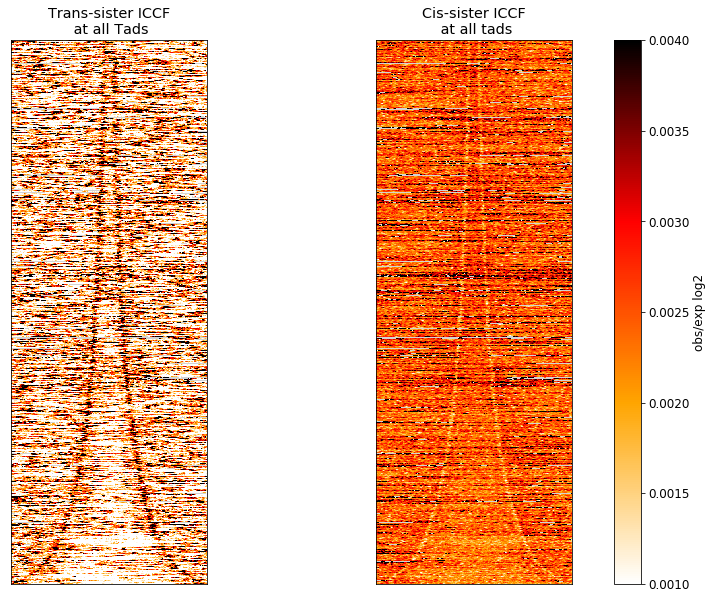

In [41]:
cmap = cl.LinearSegmentedColormap.from_list("fall", colors=["white", "orange" ,"red", "black"], N=256)
cmap.set_bad("lightgrey")

f, ax = plt.subplots(1, 2)
im = ax[0].imshow(allTADsResult["trans"], vmin=0.001, vmax=0.004, cmap=cmap, aspect=0.15)
ax[1].imshow(allTADsResult["cis"], vmin=0.03, vmax=0.09, cmap=cmap, aspect=0.15)
ax[0].set(title="Trans-sister ICCF\n at all Tads")
ax[1].set(title="Cis-sister ICCF\n at all tads")
f.colorbar(im, ax=ax, label="obs/exp log2")
# remove ticklabels
for i in range(2):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
f.set_size_inches(15, 10)
plt.show()

In [42]:
resultsdir = "/groups/gerlich/experiments/Experiments_004800/004869/Results/Nipbl/"
f.savefig(os.path.join(resultsdir, "TADs_sorted_size_WT.png"), bbox_inches="tight")
f.savefig(os.path.join(resultsdir, "TADs_sorted_size_WT.pdf"), bbox_inches="tight")

# Nipbl (ICCF)

In [36]:
HICPATHNipbl = "./Sequencing_data/Pooled/cooler/"

BINSIZE = 20000
BARCODE = "G2.Nipbl-AID.wAuxin"
clrsNipbl = {interType:
        cooler.Cooler(
            os.path.join(HICPATHNipbl, f'{BARCODE}.{interType}.1000.mcool::/resolutions/{BINSIZE}'))
        for interType in ["cis", "trans"]}

In [37]:
pileupIndICCFNipbl = {interType: HT.doPileupICCF(clrsNipbl[interType], windowsTADs, collapse=False)
                       for interType in ["cis", "trans"]}

In [38]:
allTADs1dICCFNipbl = {}
for rType in ["cis", "trans"]:
    tempPile = pileupIndICCFNipbl[rType]
    tempList = []
    for boundaryIndex in range(tempPile.shape[2]):
        if boundaryIndex % 1000 == 0:
            print(boundaryIndex)
        indPile = tempPile[:, :, boundaryIndex]
        # blank out diagonal
        indPile[np.diag_indices_from(indPile)] = np.nan
        xVals, yVals = slidingDiamond(indPile, sideLen=5)
        tempFrame = pd.DataFrame({"xVals": xVals, "yVals": yVals, "ID": boundaryIndex})
        tempList.append(tempFrame)
    allTADs1dICCFNipbl[rType] = pd.concat(tempList)

0
1000
2000
3000
4000
5000
0
1000
2000
3000
4000
5000


In [39]:
allTADsResultNipbl = {}
for rType in ["cis", "trans"]:
    temp = allTADs1dICCFNipbl[rType]
    # expand into heatmap
    tempExp = pd.pivot_table(temp, columns="xVals", index="ID", values="yVals", dropna=False)
    # sort by size
    tempExp = tempExp.loc[sortedSize,:].dropna(how="all")
    allTADsResultNipbl[rType] = tempExp

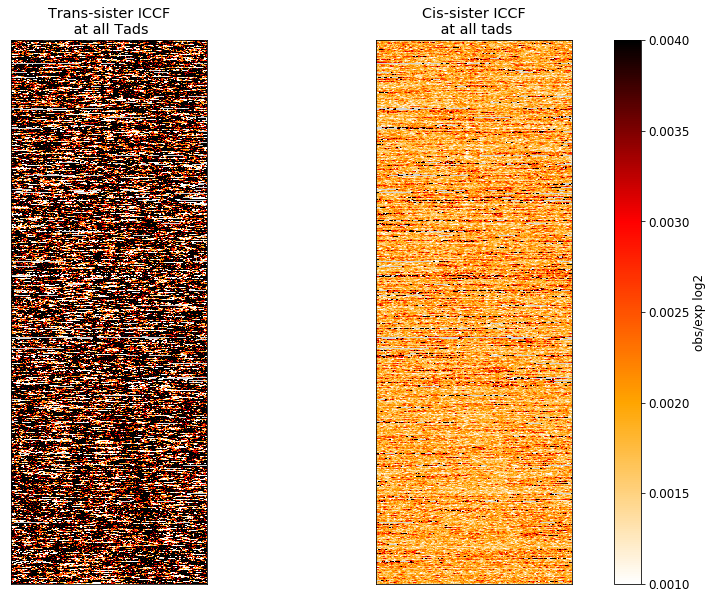

In [43]:
cmap = cl.LinearSegmentedColormap.from_list("fall", colors=["white", "orange" ,"red", "black"], N=256)
cmap.set_bad("lightgrey")

f, ax = plt.subplots(1, 2)
im = ax[0].imshow(allTADsResultNipbl["trans"], vmin=0.001, vmax=0.004, cmap=cmap, aspect=0.15)
ax[1].imshow(allTADsResultNipbl["cis"], vmin=0.03, vmax=0.09, cmap=cmap, aspect=0.15)
ax[0].set(title="Trans-sister ICCF\n at all Tads")
ax[1].set(title="Cis-sister ICCF\n at all tads")
f.colorbar(im, ax=ax, label="obs/exp log2")
# remove ticklabels
for i in range(2):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
f.set_size_inches(15, 10)
plt.show()

In [44]:
resultsdir = "/groups/gerlich/experiments/Experiments_004800/004869/Results/Nipbl/"
f.savefig(os.path.join(resultsdir, "TADs_sorted_size_Nipbl.png"), bbox_inches="tight")
f.savefig(os.path.join(resultsdir, "TADs_sorted_size_Nipbl.pdf"), bbox_inches="tight")

## WT (Obs/exp)

In [45]:
pileupIndObsExp = {interType: HT.doPileupObsExp(clrs[interType], expWT[interType] ,windowsTADs, collapse=False)
                 for interType in ["cis", "trans"]}

In [46]:
allTADs1dObsExp = {}
for rType in ["cis", "trans"]:
    tempPile = pileupIndObsExp[rType]
    tempList = []
    for boundaryIndex in range(tempPile.shape[2]):
        if boundaryIndex % 1000 == 0:
            print(boundaryIndex)
        indPile = tempPile[:, :, boundaryIndex]
        # blank out diagonal
        indPile[np.diag_indices_from(indPile)] = np.nan
        xVals, yVals = slidingDiamond(indPile, sideLen=5)
        tempFrame = pd.DataFrame({"xVals": xVals, "yVals": yVals, "ID": boundaryIndex})
        tempList.append(tempFrame)
    allTADs1dObsExp[rType] = pd.concat(tempList)

0
1000
2000
3000
4000
5000
0
1000
2000
3000
4000
5000


In [48]:
allTADsResultObsExp = {}
for rType in ["cis", "trans"]:
    temp = allTADs1dObsExp[rType]
    # expand into heatmap
    tempExp = pd.pivot_table(temp, columns="xVals", index="ID", values="yVals", dropna=False)
    # sort by size
    tempExp = tempExp.loc[sortedSize,:].dropna(how="all")
    allTADsResultObsExp[rType] = tempExp

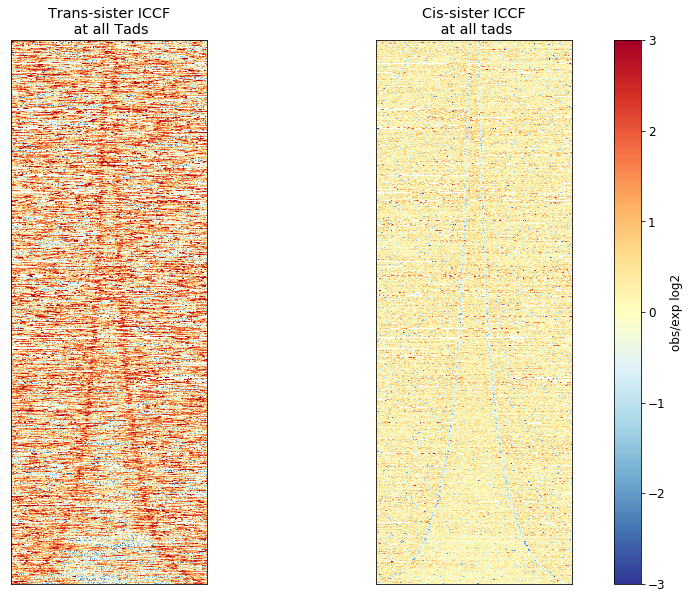

In [61]:
f, ax = plt.subplots(1, 2)
im = ax[0].imshow(np.log2(allTADsResultObsExp["trans"]), vmin=-3, vmax=3, cmap="RdYlBu_r", aspect=0.15)
ax[1].imshow(np.log2(allTADsResultObsExp["cis"]), vmin=-3, vmax=3, cmap="RdYlBu_r", aspect=0.15)
ax[0].set(title="Trans-sister ICCF\n at all Tads")
ax[1].set(title="Cis-sister ICCF\n at all tads")
f.colorbar(im, ax=ax, label="obs/exp log2")
# remove ticklabels
for i in range(2):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
f.set_size_inches(15, 10)
plt.show()

In [62]:
resultsdir = "/groups/gerlich/experiments/Experiments_004800/004869/Results/Nipbl/"
f.savefig(os.path.join(resultsdir, "TADs_sorted_size_WT_Obs_exp.png"), bbox_inches="tight")
f.savefig(os.path.join(resultsdir, "TADs_sorted_size_WT_Obs_exp.pdf"), bbox_inches="tight")

## Nipbl (Obs/Exp)

In [56]:
pileupIndObsExpNipbl = {interType: HT.doPileupObsExp(clrsNipbl[interType], expNipbl[interType] ,windowsTADs, collapse=False)
                 for interType in ["cis", "trans"]}

In [57]:
allTADs1dObsExpNipbl = {}
for rType in ["cis", "trans"]:
    tempPile = pileupIndObsExpNipbl[rType]
    tempList = []
    for boundaryIndex in range(tempPile.shape[2]):
        if boundaryIndex % 1000 == 0:
            print(boundaryIndex)
        indPile = tempPile[:, :, boundaryIndex]
        # blank out diagonal
        indPile[np.diag_indices_from(indPile)] = np.nan
        xVals, yVals = slidingDiamond(indPile, sideLen=5)
        tempFrame = pd.DataFrame({"xVals": xVals, "yVals": yVals, "ID": boundaryIndex})
        tempList.append(tempFrame)
    allTADs1dObsExpNipbl[rType] = pd.concat(tempList)

0
1000
2000
3000
4000
5000
0
1000
2000
3000
4000
5000


In [58]:
allTADsResultObsExpNipbl = {}
for rType in ["cis", "trans"]:
    temp = allTADs1dObsExpNipbl[rType]
    # expand into heatmap
    tempExp = pd.pivot_table(temp, columns="xVals", index="ID", values="yVals", dropna=False)
    # sort by size
    tempExp = tempExp.loc[sortedSize,:].dropna(how="all")
    allTADsResultObsExpNipbl[rType] = tempExp

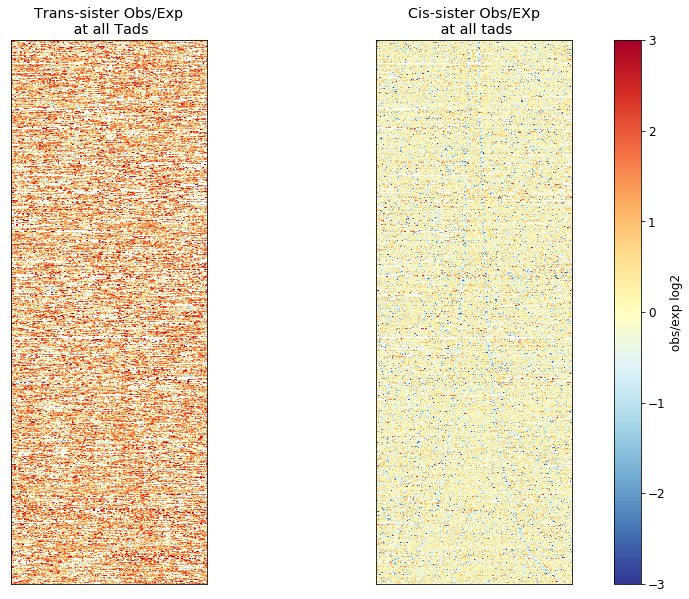

In [63]:
f, ax = plt.subplots(1, 2)
im = ax[0].imshow(np.log2(allTADsResultObsExpNipbl["trans"]), vmin=-3, vmax=3, cmap="RdYlBu_r", aspect=0.15)
ax[1].imshow(np.log2(allTADsResultObsExpNipbl["cis"]), vmin=-3, vmax=3, cmap="RdYlBu_r", aspect=0.15)
ax[0].set(title="Trans-sister Obs/Exp\n at all Tads")
ax[1].set(title="Cis-sister Obs/EXp\n at all tads")
f.colorbar(im, ax=ax, label="obs/exp log2")
# remove ticklabels
for i in range(2):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
f.set_size_inches(15, 10)
plt.show()

In [64]:
resultsdir = "/groups/gerlich/experiments/Experiments_004800/004869/Results/Nipbl/"
f.savefig(os.path.join(resultsdir, "TADs_sorted_size_Nipbl_Obs_exp.png"), bbox_inches="tight")
f.savefig(os.path.join(resultsdir, "TADs_sorted_size_Nipbl_Obs_exp.pdf"), bbox_inches="tight")